In [1]:
import numpy as np
import matplotlib.pyplot as plt

# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn import linear_model # ridge regression
from scipy.special import expit

# Models

In [26]:
class LeastSquares(object):
    """
    Least squares
    
    min_x||Ax - b||_2^2
    
    A in R^(n x d)
    b in R^n
    x in R^d
    """
    
    def __init__(self, A, b):
        
        # data
        self.A = A
        self.b = b
        
        self.d = A.shape[1]
        self.n = A.shape[0]
        
        # lipshitz constant
        self.L_F = np.linalg.norm(A)**2 #* (1.0/self.n)
        self.mu_F = 0
        
    def F(self, x):
        return .5 * sum((np.dot(self.A, x) - self.b)**2)
    
    def grad_F(self, x):
        return np.dot(self.A.T, np.dot(self.A, x) - b) 
    
    def f(self, x, i):
        return self.n*.5*(np.dot(self.A[i, :], x) - self.b[i])**2
    
    def grad_f(self, x, i):
        return self.n*(np.dot(self.A[i, :], x) - self.b[i]) * self.A[i, :]

In [86]:

class LeastSquaresL2(object):
    """
    L2 regularized Least squares
    
    min_x ||Ax - b||_2^2 + alpha ||x||_2^2
    
    A in R^(n x d)
    b in R^n
    alpha >0
    x in R^d
    """
    
    def __init__(self, A, b, alpha):
        
        # data
        self.A = A
        self.b = b
        self.alpha = alpha
        
        self.d = A.shape[1]
        self.n = A.shape[0]
        
        # lipshitz constant
        self.L_F = np.linalg.norm(A)**2 + alpha # * (1.0/self.n) 
        self.mu_F = alpha
        
    def F(self, x):
        return .5*sum((np.dot(self.A, x) - self.b)**2) + self.alpha*np.linalg.norm(x)**2
    
    def grad_F(self, x):
        return np.dot(self.A.T, np.dot(self.A, x) - b) + self.alpha*x
    
    def f(self, x, i):
        return self.n*.5*(np.dot(self.A[i, :], x) - self.b[i])**2 + self.alpha*np.linalg.norm(x)**2
    
    def grad_f(self, x, i):
        return self.n*(np.dot(self.A[i, :], x) - self.b[i])*self.A[i, :] + self.alpha*x

In [368]:
class LogisticRegression(object):
    """
    Logistic regression
    
    min_x sum_i log(1 + exp(b_i *a_i^Tx))
    
    A in R^(n x d) assumes the last column is all ones for the intercet
    b =+/-1 in R^n
    x in R^d
    
    """
    
    def __init__(self, A, b):
        
        # data
        self.A = A
        self.b = b
        self.alpha = alpha
        
        self.d = A.shape[1]
        self.n = A.shape[0]
        
        # lipshitz constant
        self.L_F = .25 * np.linalg.norm(np.dot(A.T, A))
        
    def F(self, x):
        # return np.sum(np.log(1 + np.exp(np.multiply(self.b, np.dot(self.A, x)))))
        return -1*logistic_loss(self.A, self.b, x)
    
    def grad_F(self, x):
        return -1*logistic_loss_grad(self.A, self.b, x)
    
    def f(self, x, i):
        return -1*self.n*logistic_loss(self.A[i, :], self.b[i], x)
    
    def grad_f(self, x, i):
        return -1*self.n*logistic_loss_grad(self.A[i, :], self.b[i], x)
    
    
def logistic_loss(X, y, beta):
    """ sum_i log(1 + exp(y_i *x_i^T beta))"""
    return np.sum(np.log(1 + np.exp(np.multiply(y, np.dot(X, beta)))))
    
def logistic_loss_grad(X, y, beta):
#     E = expit(-1*np.multiply(y, np.dot(X, beta)))
#     Eb = np.multiply(E, y).T
#     return np.sum(np.dot(np.diag(Eb), X), axis=0)
    if not hasattr(y, "__len__"):
        y01 = int(0 < y)
        p = expit(np.dot(X, beta))
        grad = X * (y01 - p)
    else:    
        p = expit(np.dot(X, beta))    
        y01 = [1 if label > 0 else 0 for label in y]
        grad = np.dot(X.T, y01 - p)

    return grad



# test data

In [78]:
np.random.seed(3312)

# sample data for LS problems
n = 100
d = 10

A = np.random.normal(loc=0, scale=1, size=(n, d))
b = np.random.normal(loc=0, scale=1, size=n)

In [79]:
# Least squares
model = LeastSquares(A, b)

# analytic solution
x_solution = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T),b)

In [80]:
# Least squares L2 regularized
alpha = 1

model = LeastSquaresL2(A, b, alpha)

# check solution using sklean
sk_ridge_model = linear_model.Ridge(alpha = alpha, fit_intercept=False)
sk_ridge_model.fit(X=A, y=b)
x_solution = sk_ridge_model.coef_

In [377]:
np.random.seed(3312)

# sample data for log reg problems
n = 100
d = 10

# X data with intercept
Ax = np.random.normal(loc=0, scale=1, size=(n, d-1))
A = np.array(np.bmat([Ax, np.ones((n,1))])) # add intercept to design matrix

# true beta
beta_platon = np.random.normal(loc=0, scale=1, size=d )

# sample data
prob = expit(np.dot(A, beta_platon))
unif = np.random.sample(n)
b = [1 if unif[i] < prob[i] else -1 for i in range(n)] # class labels

In [378]:
model = LogisticRegression(A, b)

# model test functions

In [369]:
x_test = np.random.normal(loc=0, scale=10, size=d)

In [370]:
# make sure F and f line up (norm of diference)
np.linalg.norm(np.mean([model.f(x_test, i) for i in range(n)]) - model.F(x_test))

1.1368683772161603e-13

In [371]:
# make sure grad_F and grad_f line up (norm of diference)
np.linalg.norm((1.0/n)*sum([model.grad_f(x_test, i) for i in range(n)]) - model.grad_F(x_test))

4.1942339212815207e-14

In [372]:
# check gradient at 0
np.linalg.norm(model.grad_F(x_solution))

36.226461615124244

# optimization algos

In [357]:
def gradient_descent(model, eta, max_iterations=1e4, epsilon=1e-5, x_start=None):
    """
    Gradient descent
    """

    # data from model
    grad_F = model.grad_F
    # F = model.F
    
    # initialization
    if x_start:
        x_current = x_start
    else:
        x_current = np.random.normal(loc=0, scale=1, size=d)


    # history
    x_history = []

    for k in range(int(max_iterations)):
        # history
        x_history.append(x_current)
        
        # gradient update
        x_next = x_current - eta * grad_F(x_current)

        # relative error stoping condition
        if np.linalg.norm(x_next - x_current) <= epsilon*np.linalg.norm(x_current):
            break
            # if np.linalg.norm(x_next) <= epsilon:

        x_current = x_next


    print 'GD finished after ' + str(k) + ' iterations'
    
    return {'solution': x_current,
            'x_history': x_history}

In [34]:
def accelerated_gradient_descent(model, eta, max_iterations=1e4, epsilon=1e-5, x_start=None):
    """
    Nesterov's accelerated gradient descent
    """

    # data from model
    grad_F = model.grad_F
    # F = model.F
    
    # initialization
    if x_start:
        x_current = x_start
    else:
        x_current = np.random.normal(loc=0, scale=1, size=d)

    y_current = x_current
    t_current = 1.0

    # history
    x_history = []

    for k in range(int(max_iterations)):
        # history
        x_history.append(x_current)
        
        # gradient update
        t_next = .5*(1 + np.sqrt(1 + 4*t_current**2))
        x_next = y_current - eta * grad_F(y_current)
        y_next = x_next +(t_current - 1.0)/(t_next)*(x_next - x_current)

        # relative error stoping condition
        if np.linalg.norm(x_next - x_current) <= epsilon*np.linalg.norm(x_current):
            break
            # if np.linalg.norm(x_next) <= epsilon:

        # restarting strategies
        if np.dot(y_current - x_next, x_next - x_current) > 0:
            y_next = x_next
            t_next = 1
            # if k %% k_restart == 0: 
        
        x_current = x_next
        y_current = y_next
        t_current = t_next


    print 'accelerated GD finished after ' + str(k) + ' iterations'
    
    return {'solution': x_current,
            'x_history': x_history}

In [35]:
def stochastic_gradient_descent(model, eta, batch_size=1, max_iterations=1e4, epsilon=1e-5, x_start=None, seed=None):
    """
    Stochastic gradient with linearly decaying learning rate
    """
    if seed:
        np.random.seed(seed)

    
    # data from model
    n = model.n # number of data points

    grad_F = model.grad_F
    F = model.F
    
    # initialization
    if x_start:
        x_current = x_start
    else:
        x_current = np.random.normal(loc=0, scale=1, size=d)

    # history
    x_history = []

    for k in range(int(max_iterations)):

        x_history.append(x_current)
        
        # compute gradient estimate
        index = np.random.choice(n, batch_size)
        batch_grad =  np.mean([model.grad_f(x_current, i) for i in index], axis=0)
        
        # gradient update 
        x_next = x_current - eta/(k + 1.0)*batch_grad

        # relative error stoping condition
        if np.linalg.norm(x_next - x_current) <= epsilon*np.linalg.norm(x_current):
            break

        x_current = x_next


    print 'SGD finished after ' + str(k) + ' iterations'
    
    return {'solution': x_current,
            'x_history': x_history}

# Run optimization algos

### GD on LS

In [383]:
%%time
eta = 1/model.L_F

GD = gradient_descent(model, eta)

GD finished after 820 iterations
CPU times: user 42.6 ms, sys: 2.52 ms, total: 45.1 ms
Wall time: 43 ms


In [384]:
x_history = GD['x_history']

In [385]:
x_error = [np.linalg.norm(x_solution - x) for x in x_history]
fun_history = [model.F(x)  for x in x_history]
grad_history = [np.linalg.norm(model.grad_F(x))  for x in x_history]

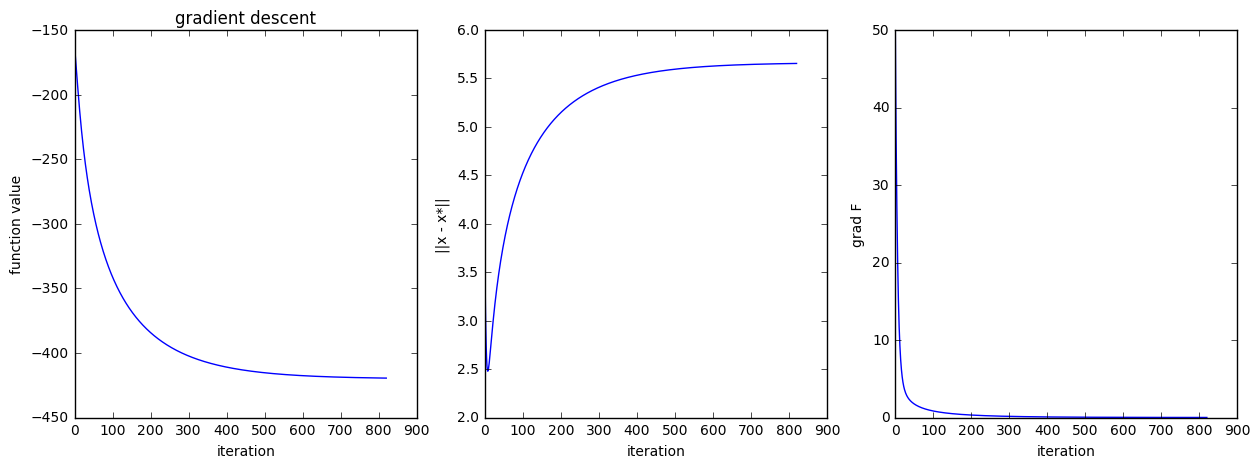

In [386]:
plt.figure(figsize=[15, 5])

plt.subplot(1,3,1)
plt.plot(fun_history)
plt.ylabel('function value')
plt.xlabel('iteration')
plt.title('gradient descent')

plt.subplot(1,3,2)
plt.plot(x_error)
plt.ylabel('||x - x*||')
plt.xlabel('iteration')

plt.subplot(1,3,3)
plt.plot(grad_history)
plt.ylabel('grad F')
plt.xlabel('iteration')

### accel GD on LS

In [ ]:
%%time
eta = 1.0/model.L_F

AGD = accelerated_gradient_descent(model, eta, epsilon=1e-10)

In [ ]:
x_history = AGD['x_history']

In [ ]:
x_error = [np.linalg.norm(x_solution - x) for x in x_history]
fun_history = [model.F(x)  for x in x_history]
grad_history = [np.linalg.norm(model.grad_F(x))  for x in x_history]

In [ ]:
plt.figure(figsize=[15, 5])

plt.subplot(1,3,1)
plt.plot(fun_history)
plt.ylabel('function value')
plt.xlabel('iteration')
plt.title('gradient descent')

plt.subplot(1,3,2)
plt.plot(x_error)
plt.ylabel('||x - x*||')
plt.xlabel('iteration')

plt.subplot(1,3,3)
plt.plot(grad_history)
plt.ylabel('grad F')
plt.xlabel('iteration')

### SGD on LS

In [56]:
%%time
# eta = .01/(2.0*model.mu_F)
eta = 1e-2

SGD = stochastic_gradient_descent(model, eta,batch_size=1, max_iterations=1e4, epsilon=1e-10)

SGD finished after 9999 iterations
CPU times: user 483 ms, sys: 3.15 ms, total: 486 ms
Wall time: 485 ms


In [57]:
x_history = SGD['x_history']

x_error = [np.linalg.norm(x_solution - x) for x in x_history]
fun_history = [model.F(x)  for x in x_history]
grad_history = [np.linalg.norm(model.grad_F(x))  for x in x_history]

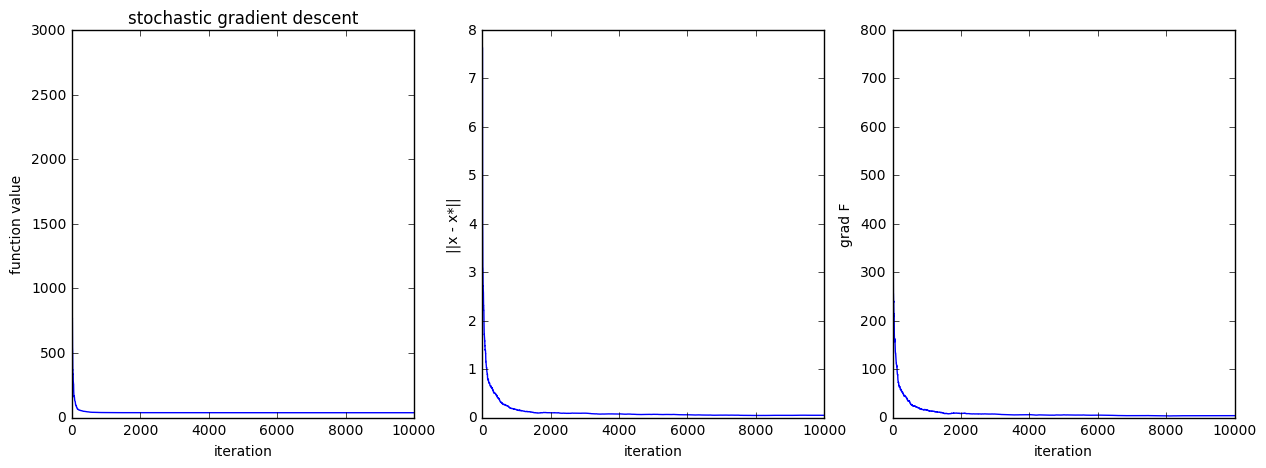

In [58]:
plt.figure(figsize=[15, 5])

plt.subplot(1,3,1)
plt.plot(fun_history)
plt.ylabel('function value')
plt.xlabel('iteration')
plt.title('stochastic gradient descent')

plt.subplot(1,3,2)
plt.plot(x_error)
plt.ylabel('||x - x*||')
plt.xlabel('iteration')

plt.subplot(1,3,3)
plt.plot(grad_history)
plt.ylabel('grad F')
plt.xlabel('iteration')

In [59]:
print min(x_error)
print max(x_error)
print x_error[-1]

0.0403946248322
7.65006369448
0.0452351914252


0.013192336877883933